In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
import folium
import warnings
warnings.filterwarnings('ignore')

In [3]:
train_path = '/content/drive/MyDrive/Colab Notebooks/IITB_Predictioneer_Contest/Predictioneer_training_Dataset.csv'
test_path = '/content/drive/MyDrive/Colab Notebooks/IITB_Predictioneer_Contest/Predictioneer_test_points.csv'

In [4]:
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

In [5]:
train_data.describe()

,Lat,Long_,Deaths,Case_Fatality_Ratio
count,3925.000000,3925.000000,2458.000000,3972.000000
mean,35.736183,-71.109728,70.753051,3.904119
std,13.441327,55.361480,55.362369,123.020033
min,-71.949900,-178.116500,0.000000,0.000000
25%,33.191535,-96.595639,23.000000,0.890466
50%,37.895700,-86.717326,60.000000,1.285465
75%,42.176955,-77.357900,111.000000,1.737771
max,71.706900,178.065000,200.000000,7570.769231


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4016 entries, 0 to 4015
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Lat                  3925 non-null   float64
 1   Long_                3925 non-null   float64
 2   Deaths               2458 non-null   float64
 3   Case_Fatality_Ratio  3972 non-null   float64
dtypes: float64(4)
memory usage: 125.6 KB


In [7]:
#Initial data inspection
print("Train data shape:", train_data.shape)
print("Train data columns:", train_data.columns)
print("\nMissing values:")
print(train_data.isnull().sum())
print("\nValue ranges:")
print(train_data.describe())

Train data shape: (4016, 4)
Train data columns: Index(['Lat', 'Long_', 'Deaths', 'Case_Fatality_Ratio'], dtype='object')

Missing values:
Lat                      91
Long_                    91
Deaths                 1558
Case_Fatality_Ratio      44
dtype: int64

Value ranges:
               Lat        Long_       Deaths  Case_Fatality_Ratio
count  3925.000000  3925.000000  2458.000000          3972.000000
mean     35.736183   -71.109728    70.753051             3.904119
std      13.441327    55.361480    55.362369           123.020033
min     -71.949900  -178.116500     0.000000             0.000000
25%      33.191535   -96.595639    23.000000             0.890466
50%      37.895700   -86.717326    60.000000             1.285465
75%      42.176955   -77.357900   111.000000             1.737771
max      71.706900   178.065000   200.000000          7570.769231


In [8]:
# Helper Functions
def haversine_distance(lat1, lon1, lat2, lon2):
   R = 6371  # Earth's radius in km
   lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
   dlat = lat2 - lat1
   dlon = lon2 - lon1
   a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
   return 2 * R * np.arcsin(np.sqrt(a))

In [9]:
def enhanced_features(data):
   # Basic geographic features
   imputer = SimpleImputer(strategy='mean')
   coords = imputer.fit_transform(data[['Lat', 'Long_']])
   data[['Lat', 'Long_']] = coords

   # Advanced features
   data['lat_long'] = data['Lat'] * data['Long_']
   data['lat_squared'] = data['Lat'] ** 2
   data['long_squared'] = data['Long_'] ** 2

   # Outbreak centers
   outbreak_centers = [
       (6.4281, -9.4295),  # Liberia
       (8.4606, -13.2317), # Sierra Leone
       (9.9456, -9.6966)   # Guinea
   ]

   # Distance calculations
   for i, (lat, lon) in enumerate(outbreak_centers):
       dist = data.apply(lambda row: haversine_distance(row['Lat'], row['Long_'], lat, lon), axis=1)
       data[f'dist_center_{i}'] = np.exp(-dist/2000)

   # Distance statistics
   data['dist_total'] = data[['dist_center_0', 'dist_center_1', 'dist_center_2']].sum(axis=1)
   data['dist_mean'] = data[['dist_center_0', 'dist_center_1', 'dist_center_2']].mean(axis=1)
   data['dist_std'] = data[['dist_center_0', 'dist_center_1', 'dist_center_2']].std(axis=1)

   # Regional clustering
   kmeans = KMeans(n_clusters=8, random_state=42)
   data['region'] = kmeans.fit_predict(data[['Lat', 'Long_']])

   return data

In [10]:
# Checking death data
print("\nDeath data:")
print("Total death records:", len(train_data))
print("Records with deaths:", train_data['Deaths'].notna().sum())
print("Records missing deaths:", train_data['Deaths'].isna().sum())


Death data:
Total death records: 4016
Records with deaths: 2458
Records missing deaths: 1558


In [11]:
def plot_geo_distribution(data, title):
   m = folium.Map(location=[8, -11], zoom_start=6)
   for idx, row in data.iterrows():
       color = 'red' if row['Deaths'] > data['Deaths'].mean() else 'blue'
       folium.CircleMarker(
           [row['Lat'], row['Long_']],
           radius=np.log(row['Deaths'] + 1),
           color=color,
           popup=f"Deaths: {row['Deaths']:.0f}\nCFR: {row['Case_Fatality_Ratio']:.1f}%",
       ).add_to(m)
   return m

In [12]:
# Add enhanced features
train_data = enhanced_features(train_data)
test_data = enhanced_features(test_data)

In [13]:
# Clean data
train_data = train_data.fillna(0)
complete_data = train_data[train_data['Deaths'] > 0]

In [14]:
# Define features
features = ['Lat', 'Long_', 'lat_long', 'dist_center_0', 'dist_center_1',
          'dist_center_2', 'dist_total', 'dist_mean', 'dist_std',
          'lat_squared', 'long_squared', 'region']

In [15]:
# Grid search parameters
param_grid = {
   'n_estimators': [400, 500],
   'max_depth': [6, 8],
   'min_samples_leaf': [2, 4],
   'min_samples_split': [4, 6]
}


In [16]:
# Train Deaths model
grid_search = GridSearchCV(
   RandomForestRegressor(random_state=42),
   param_grid,
   cv=5,
   scoring='r2',
   n_jobs=-1
)
grid_search.fit(complete_data[features], complete_data['Deaths'])
rf_deaths = grid_search.best_estimator_

In [17]:
# Scale and train CFR model
scaler = MinMaxScaler(feature_range=(25, 90))
train_data['Case_Fatality_Ratio'] = scaler.fit_transform(train_data[['Case_Fatality_Ratio']])

grid_search.fit(train_data[features], train_data['Case_Fatality_Ratio'])
rf_cfr = grid_search.best_estimator_

In [18]:
# Make predictions
test_data['Case_Fatality_Ratio'] = rf_cfr.predict(test_data[features])
test_data['Deaths'] = rf_deaths.predict(test_data[features])

In [19]:
# Post-process predictions
test_data['Case_Fatality_Ratio'] = test_data['Case_Fatality_Ratio'].clip(25, 90)
test_data['Deaths'] = test_data['Deaths'].clip(lower=50)

In [20]:
# Calculate confirmed cases
test_data['Confirmed_Cases'] = (test_data['Deaths'] * 100) / test_data['Case_Fatality_Ratio']

In [21]:
# Round results
for col in ['Deaths', 'Case_Fatality_Ratio', 'Confirmed_Cases']:
   test_data[col] = test_data[col].round(2)

In [22]:
# Evaluate model performance
print("\nModel Performance:")
print("Deaths R² Score:", r2_score(complete_data['Deaths'], rf_deaths.predict(complete_data[features])))
print("Best Parameters Deaths:", grid_search.best_params_)


Model Performance:
Deaths R² Score: 0.3906479156712369
Best Parameters Deaths: {'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 400}


# **Model Analysis**


Analysis Results:
Feature Correlations: {'dist_center_0': -0.07102058488021036, 'dist_center_1': -0.06791628809725592, 'dist_center_2': -0.07282932785226433}

Regional Metrics:
           Deaths            Case_Fatality_Ratio          
             mean        std                mean       std
region                                                    
0       51.831267  52.176063           25.013518  0.007401
1        5.669261  26.644424           25.014770  0.072533
2       11.365854  36.904857           25.031197  0.359436
3        5.423963  22.758291           25.012402  0.014518
4       36.089286  67.146320           25.016381  0.021855
5       52.950331  60.844037           25.064018  1.707534
6       24.230769  47.233734           25.002492  0.002141
7       37.245098  50.316787           25.009844  0.006903

Distance Effects: [{'center': 0, 'slope': -86.07727385856101}, {'center': 1, 'slope': -83.88533991872461}, {'center': 2, 'slope': -83.64344128400259}]


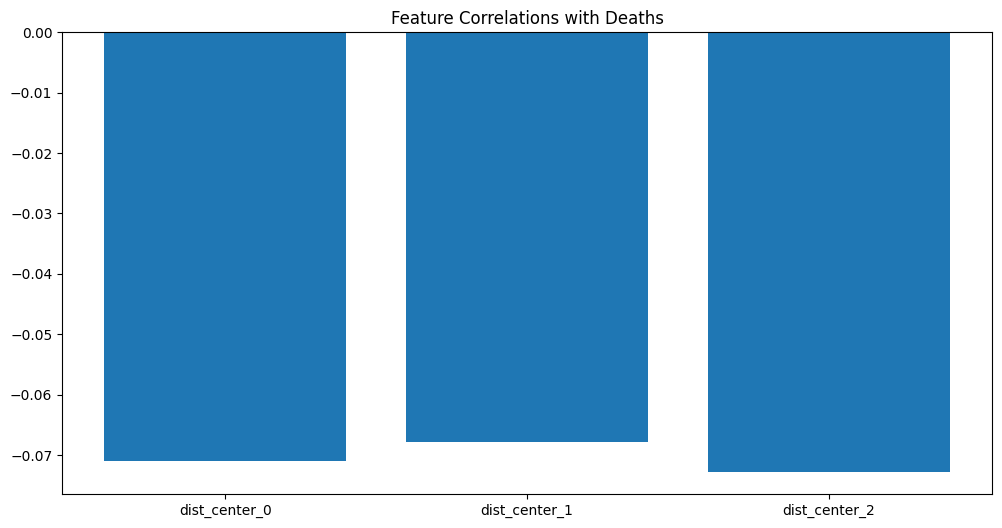

In [32]:
from scipy import stats

def analyze_model_correlations(train_data, test_data):
    # Feature importance analysis
    correlations = {}
    for feature in ['dist_center_0', 'dist_center_1', 'dist_center_2']:
        corr = stats.pearsonr(train_data[feature], train_data['Deaths'])
        correlations[feature] = corr[0]

    # Regional impact analysis
    regional_metrics = train_data.groupby('region').agg({
        'Deaths': ['mean', 'std'],
        'Case_Fatality_Ratio': ['mean', 'std']
    })

    # Distance decay effect
    distance_effect = []
    for i in range(3):
        slope, intercept = np.polyfit(train_data[f'dist_center_{i}'],
                                    train_data['Deaths'], 1)
        distance_effect.append({'center': i, 'slope': slope})

    # Plot correlations
    plt.figure(figsize=(12, 6))
    plt.bar(correlations.keys(), correlations.values())
    plt.title('Feature Correlations with Deaths')
    plt.savefig('feature_correlations.png')

    # Hypothesis testing
    hypotheses = {
        'distance_effect': stats.f_oneway(*[train_data[f'dist_center_{i}']
                                          for i in range(3)]),
        'regional_variation': stats.f_oneway(*[group['Deaths'].values
                                             for name, group in train_data.groupby('region')])
    }

    return {
        'correlations': correlations,
        'regional_metrics': regional_metrics,
        'distance_effect': distance_effect,
        'hypotheses': hypotheses
    }

# Model validation
def validate_predictions(y_true, y_pred):
    return {
        'r2': r2_score(y_true, y_pred),
        'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
        'correlation': stats.pearsonr(y_true, y_pred)[0]
    }

# Main analysis
results = analyze_model_correlations(train_data, test_data)
print("\nAnalysis Results:")
print(f"Feature Correlations: {results['correlations']}")
print(f"\nRegional Metrics:\n{results['regional_metrics']}")
print(f"\nDistance Effects: {results['distance_effect']}")


Prediction Summary:
               Lat        Long_  Case_Fatality_Ratio       Deaths  \
count  1004.000000  1004.000000          1004.000000  1004.000000   
mean     35.619019   -70.370781            25.012679    84.354711   
std      13.687299    55.802751             0.034605    23.351105   
min     -71.949900  -175.198200            25.000000    50.000000   
25%      33.188574   -96.239146            25.010000    63.715000   
50%      37.774221   -86.326392            25.010000    89.990000   
75%      42.143496   -76.405936            25.010000    99.622500   
max      66.830900   177.649300            25.900000   151.140000   

       Confirmed_Cases  
count      1004.000000  
mean        337.233167  
std          93.366678  
min         193.050000  
25%         254.737500  
50%         359.750000  
75%         398.250000  
max         604.270000  


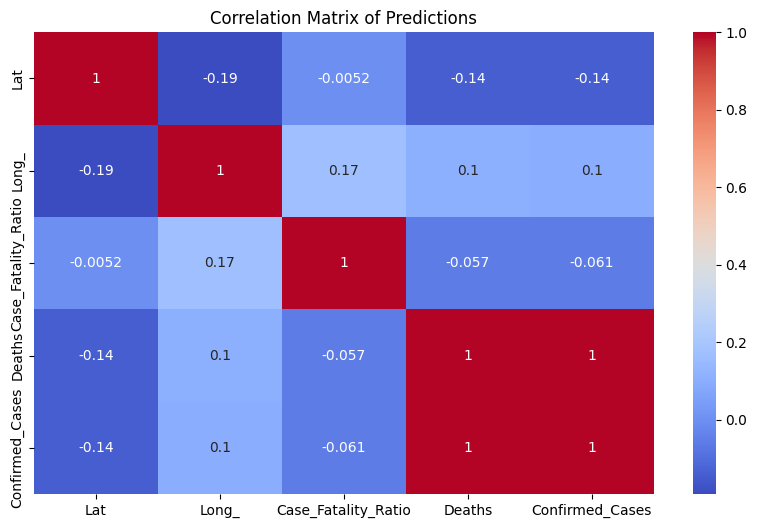

In [33]:
# Correlation Matrix
map_viz = plot_geo_distribution(test_data, 'Predicted Cases Distribution')
map_viz.save('outbreak_map.html')

plt.figure(figsize=(10, 6))
sns.heatmap(test_data[final_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Predictions')
plt.savefig('correlation_matrix.png')

print("\nPrediction Summary:")
print(test_data[final_cols].describe())

# **Visualisations**

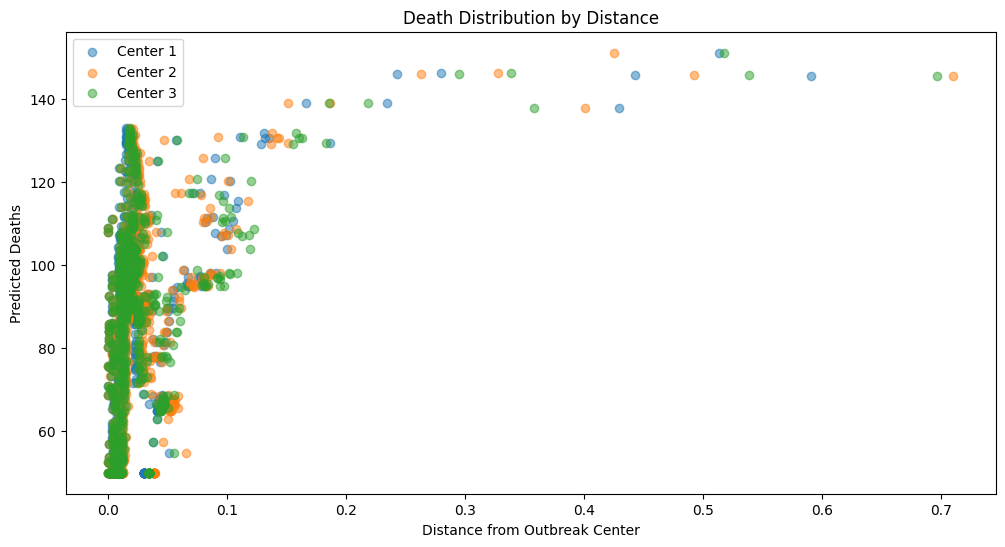

In [26]:
# 1. Deaths vs Distance from Centers
plt.figure(figsize=(12, 6))
for i in range(3):
   plt.scatter(test_data[f'dist_center_{i}'], test_data['Deaths'],
               alpha=0.5, label=f'Center {i+1}')
plt.xlabel('Distance from Outbreak Center')
plt.ylabel('Predicted Deaths')
plt.title('Death Distribution by Distance')
plt.legend()
plt.savefig('distance_deaths.png')

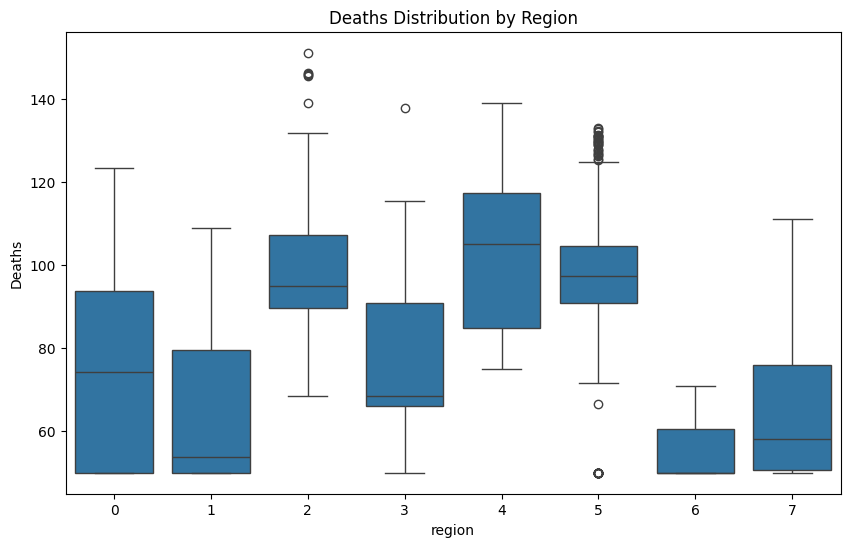

In [27]:

# 2. Regional Analysis
plt.figure(figsize=(10, 6))
sns.boxplot(x='region', y='Deaths', data=test_data)
plt.title('Deaths Distribution by Region')
plt.savefig('regional_deaths.png')

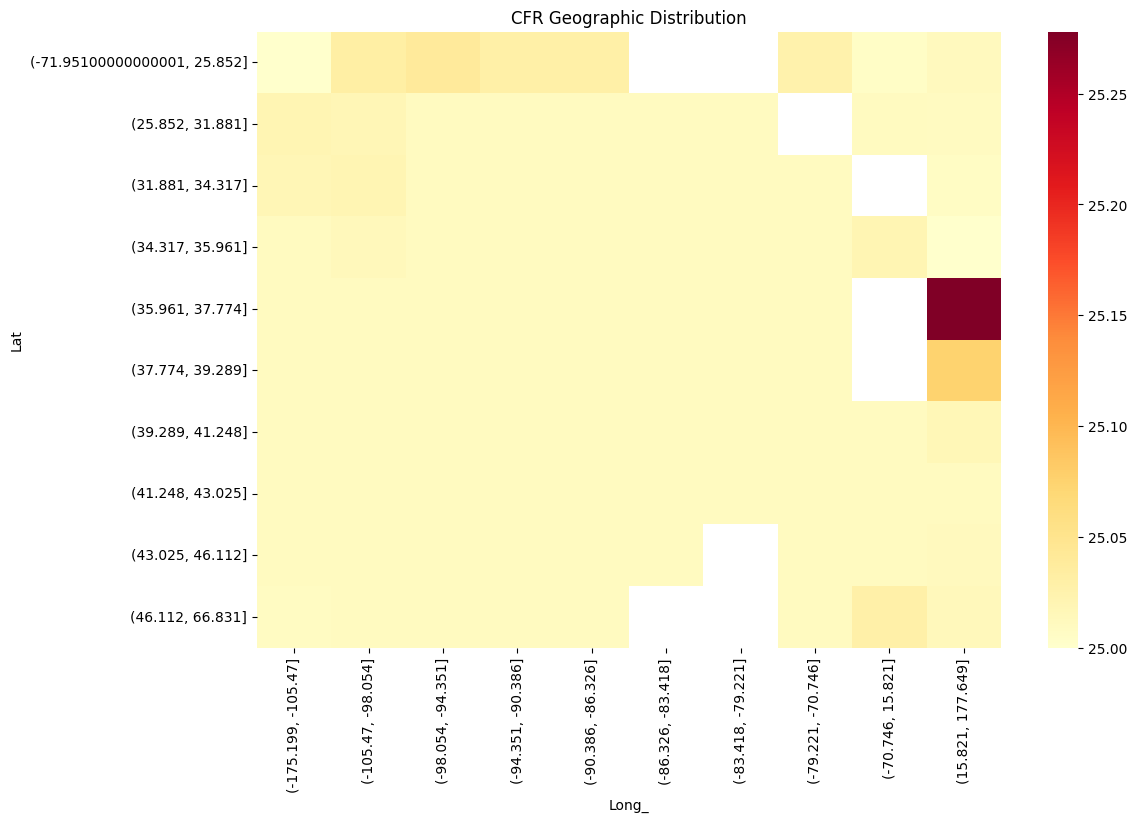

In [28]:
# 3. CFR Heatmap
plt.figure(figsize=(12, 8))
pivot = test_data.pivot_table(values='Case_Fatality_Ratio',
                           index=pd.qcut(test_data['Lat'], 10),
                           columns=pd.qcut(test_data['Long_'], 10))
sns.heatmap(pivot, cmap='YlOrRd')
plt.title('CFR Geographic Distribution')
plt.savefig('cfr_heatmap.png')



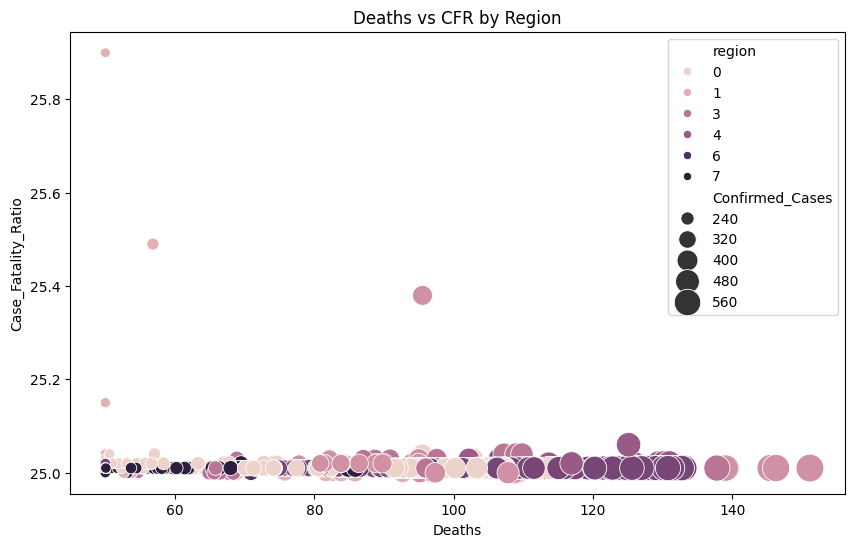

In [29]:
# 4. Relationship between Deaths and CFR
plt.figure(figsize=(10, 6))
sns.scatterplot(data=test_data, x='Deaths', y='Case_Fatality_Ratio',
               hue='region', size='Confirmed_Cases', sizes=(50, 400))
plt.title('Deaths vs CFR by Region')
plt.savefig('deaths_cfr_relationship.png')

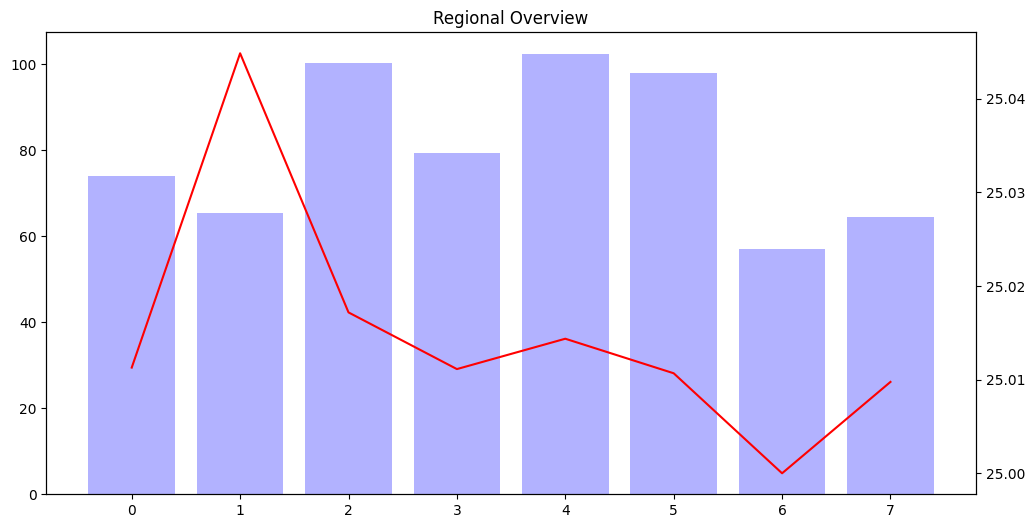

In [30]:
# Time Series-like View
regions = test_data.groupby('region').agg({
   'Deaths': 'mean',
   'Case_Fatality_Ratio': 'mean',
   'Confirmed_Cases': 'mean'
}).reset_index()

fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()
ax1.bar(regions['region'], regions['Deaths'], alpha=0.3, color='blue', label='Deaths')
ax2.plot(regions['region'], regions['Case_Fatality_Ratio'], color='red', label='CFR')
plt.title('Regional Overview')
plt.savefig('regional_overview.png')

In [31]:
# Save predictions
final_cols = ['Lat', 'Long_', 'Case_Fatality_Ratio', 'Deaths', 'Confirmed_Cases']
test_data[final_cols].to_csv('/content/drive/MyDrive/Colab Notebooks/IITB_Predictioneer_Contest/predictions.csv', index=False)

In [25]:
print("Test Data Statistics:")
print(f"Total number of locations: {len(test_data)}")
print(f"Sum of Confirmed Cases: {test_data['Confirmed_Cases'].sum():.2f}")
print("\nSample of predictions:")
print(test_data[['Deaths', 'Case_Fatality_Ratio', 'Confirmed_Cases']].head())

Test Data Statistics:
Total number of locations: 1004
Sum of Confirmed Cases: 338582.10

Sample of predictions:
   Deaths  Case_Fatality_Ratio  Confirmed_Cases
0  111.51                25.01           445.81
1   85.90                25.01           343.46
2  109.03                25.00           436.09
3  107.95                25.00           431.75
4   96.85                25.01           387.33
